In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)
pd.options.display.float_format= '{e:.5f}'.format 

In [27]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe


## Verifying equality betweeen AIB and ASHOIB

In [30]:
N = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
dim = 3 
omega = 1.
data_dict = {"Number of particles": N, "Local energy": [], "Local energy log domain": []}#, "Drift force": [], "Drift force log domain": []}
drift_dict = {"Number of particles": N, "Fx": [], "Fy": [], "Fz": [], "Fx log": [], "Fy log": [], "Fz log": []}
for i in range(len(N)): 
    n = N[i]
    wflogspace = vmc.ASHOIB(n, dim, omega)
    wf = vmc.AIB(n, dim, omega)
    positions, scale = interact_initial_positions(wflogspace, 0.5, n, dim)
    #print("Shape positions: ", positions.shape)
    local_energy = wf.local_energy(positions, 0.5)
    local_energy_log = wflogspace.local_energy(positions, 0.5)
    drift_force = wf.drift_force(positions, 0.5)
    drift_force_log = wflogspace.drift_force(positions, 0.5)
    data_dict["Local energy"].append(local_energy)
    data_dict["Local energy log domain"].append(local_energy_log)
    drift_dict["Fx"].append(drift_force[0][0])
    drift_dict["Fy"].append(drift_force[0][1])
    drift_dict["Fz"].append(drift_force[0][2])
    drift_dict["Fx log"].append(drift_force_log[0][0])
    drift_dict["Fy log"].append(drift_force_log[0][1])
    drift_dict["Fz log"].append(drift_force_log[0][2])
    
dataframe = pd.DataFrame(data=data_dict)
drift_dataframe = pd.DataFrame(data=drift_dict)

df_to_latex(dataframe, "verification_table.tex")
df_to_latex(drift_dataframe, "drift_ver_table.tex")
dataframe["Local energy"] = dataframe["Local energy"].map('{:.5f}'.format)
print(dataframe)
print(drift_dataframe)


NI part:  3.0
NI part:  7.5
NI part:  15.0
NI part:  30.0
NI part:  75.0
NI part:  150.0
NI part:  300.0
NI part:  750.0
NI part:  1500.0
   Number of particles Local energy  Local energy log domain
0                    2      3.00075                    3.001
1                    5      7.51358                    7.514
2                   10     15.05941                   15.059
3                   20     30.25000                   30.250
4                   50     76.55215                   76.552
5                  100    156.19121                  156.191
6                  200    324.81364                  324.814
7                  500    899.99809                  899.998
8                 1000   2096.06506                2,096.065
   Number of particles     Fx     Fy     Fz  Fx log  Fy log  Fz log
0                    2 -0.222 -0.084  0.770  -0.222  -0.083   0.770
1                    5  0.052  2.843  1.676   0.052   2.843   1.676
2                   10 -0.768 -6.262  1.810  -0.

In [33]:
dataframe["Local energy"] = dataframe["Local energy"].map('{:.5f}'.format)
print(dataframe)

ValueError: Unknown format code 'f' for object of type 'str'

## Grid search $\alpha$ without interactions

In [4]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_NI_N10 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions = safe_initial_positions_no_interactions(wf,
                                                               alpha,
                                                               N,
                                                               dim)
                                                   
    result = sampler_NI.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=4,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=5000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    results_NI_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm after tune doneWarm after tune done

Sampling energy
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Warm after tune done
Sampling energy
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm doneWarm done

Warm doneWarm done

Tune done
Tune done
Warm after tune done
Tune done
Sampling energy
Warm after tune done
Sampling energy
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm doneWarm done

Warm doneWarm done

Tune done
Tune done
Tune done
Warm after tune done
Sampling energy
Tune done
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm after tune done
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm aft

Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jeb/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/home/jeb/.local/lib/python3.8/site-packages/numpy/lib/stride_tricks.py", line 357, in _broadcast_to
    result.flags.writeable = True
KeyboardInterrupt


In [46]:
N=50
df_NI_N50 = pd.concat(results_NI_N10, ignore_index=True)
#mod_df_NI_50 = df_N50
df_means_NI_N50 = get_mean_w_standard_error_grid_search(df_NI_N50, alphas)
df_means_NI_N50["energy"] = df_means_NI_N50["energy"]/N
df_means_NI_N50["standard_error"] = df_means_NI_N50["standard_error"]/N
df_means_NI_N50["standard_error"] = df_means_NI_N50["standard_error"].map('{:.0e}'.format)
df_means_NI_N50["standard_error_of_the_mean"] = df_means_NI_N50["standard_error_of_the_mean"]/N
df_means_NI_N50

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.100,3.888,8e-02,0.011
1,0.200,2.144,3e-02,0.003
2,0.300,1.697,2e-02,0.001
3,0.400,1.538,9e-03,0.002
4,0.500,1.500,0e+00,0.000
5,0.600,1.516,7e-03,0.001
6,0.700,1.583,1e-02,0.001
7,0.800,1.667,2e-02,0.004
8,0.900,1.755,2e-02,0.001
9,1.000,1.885,3e-02,0.003


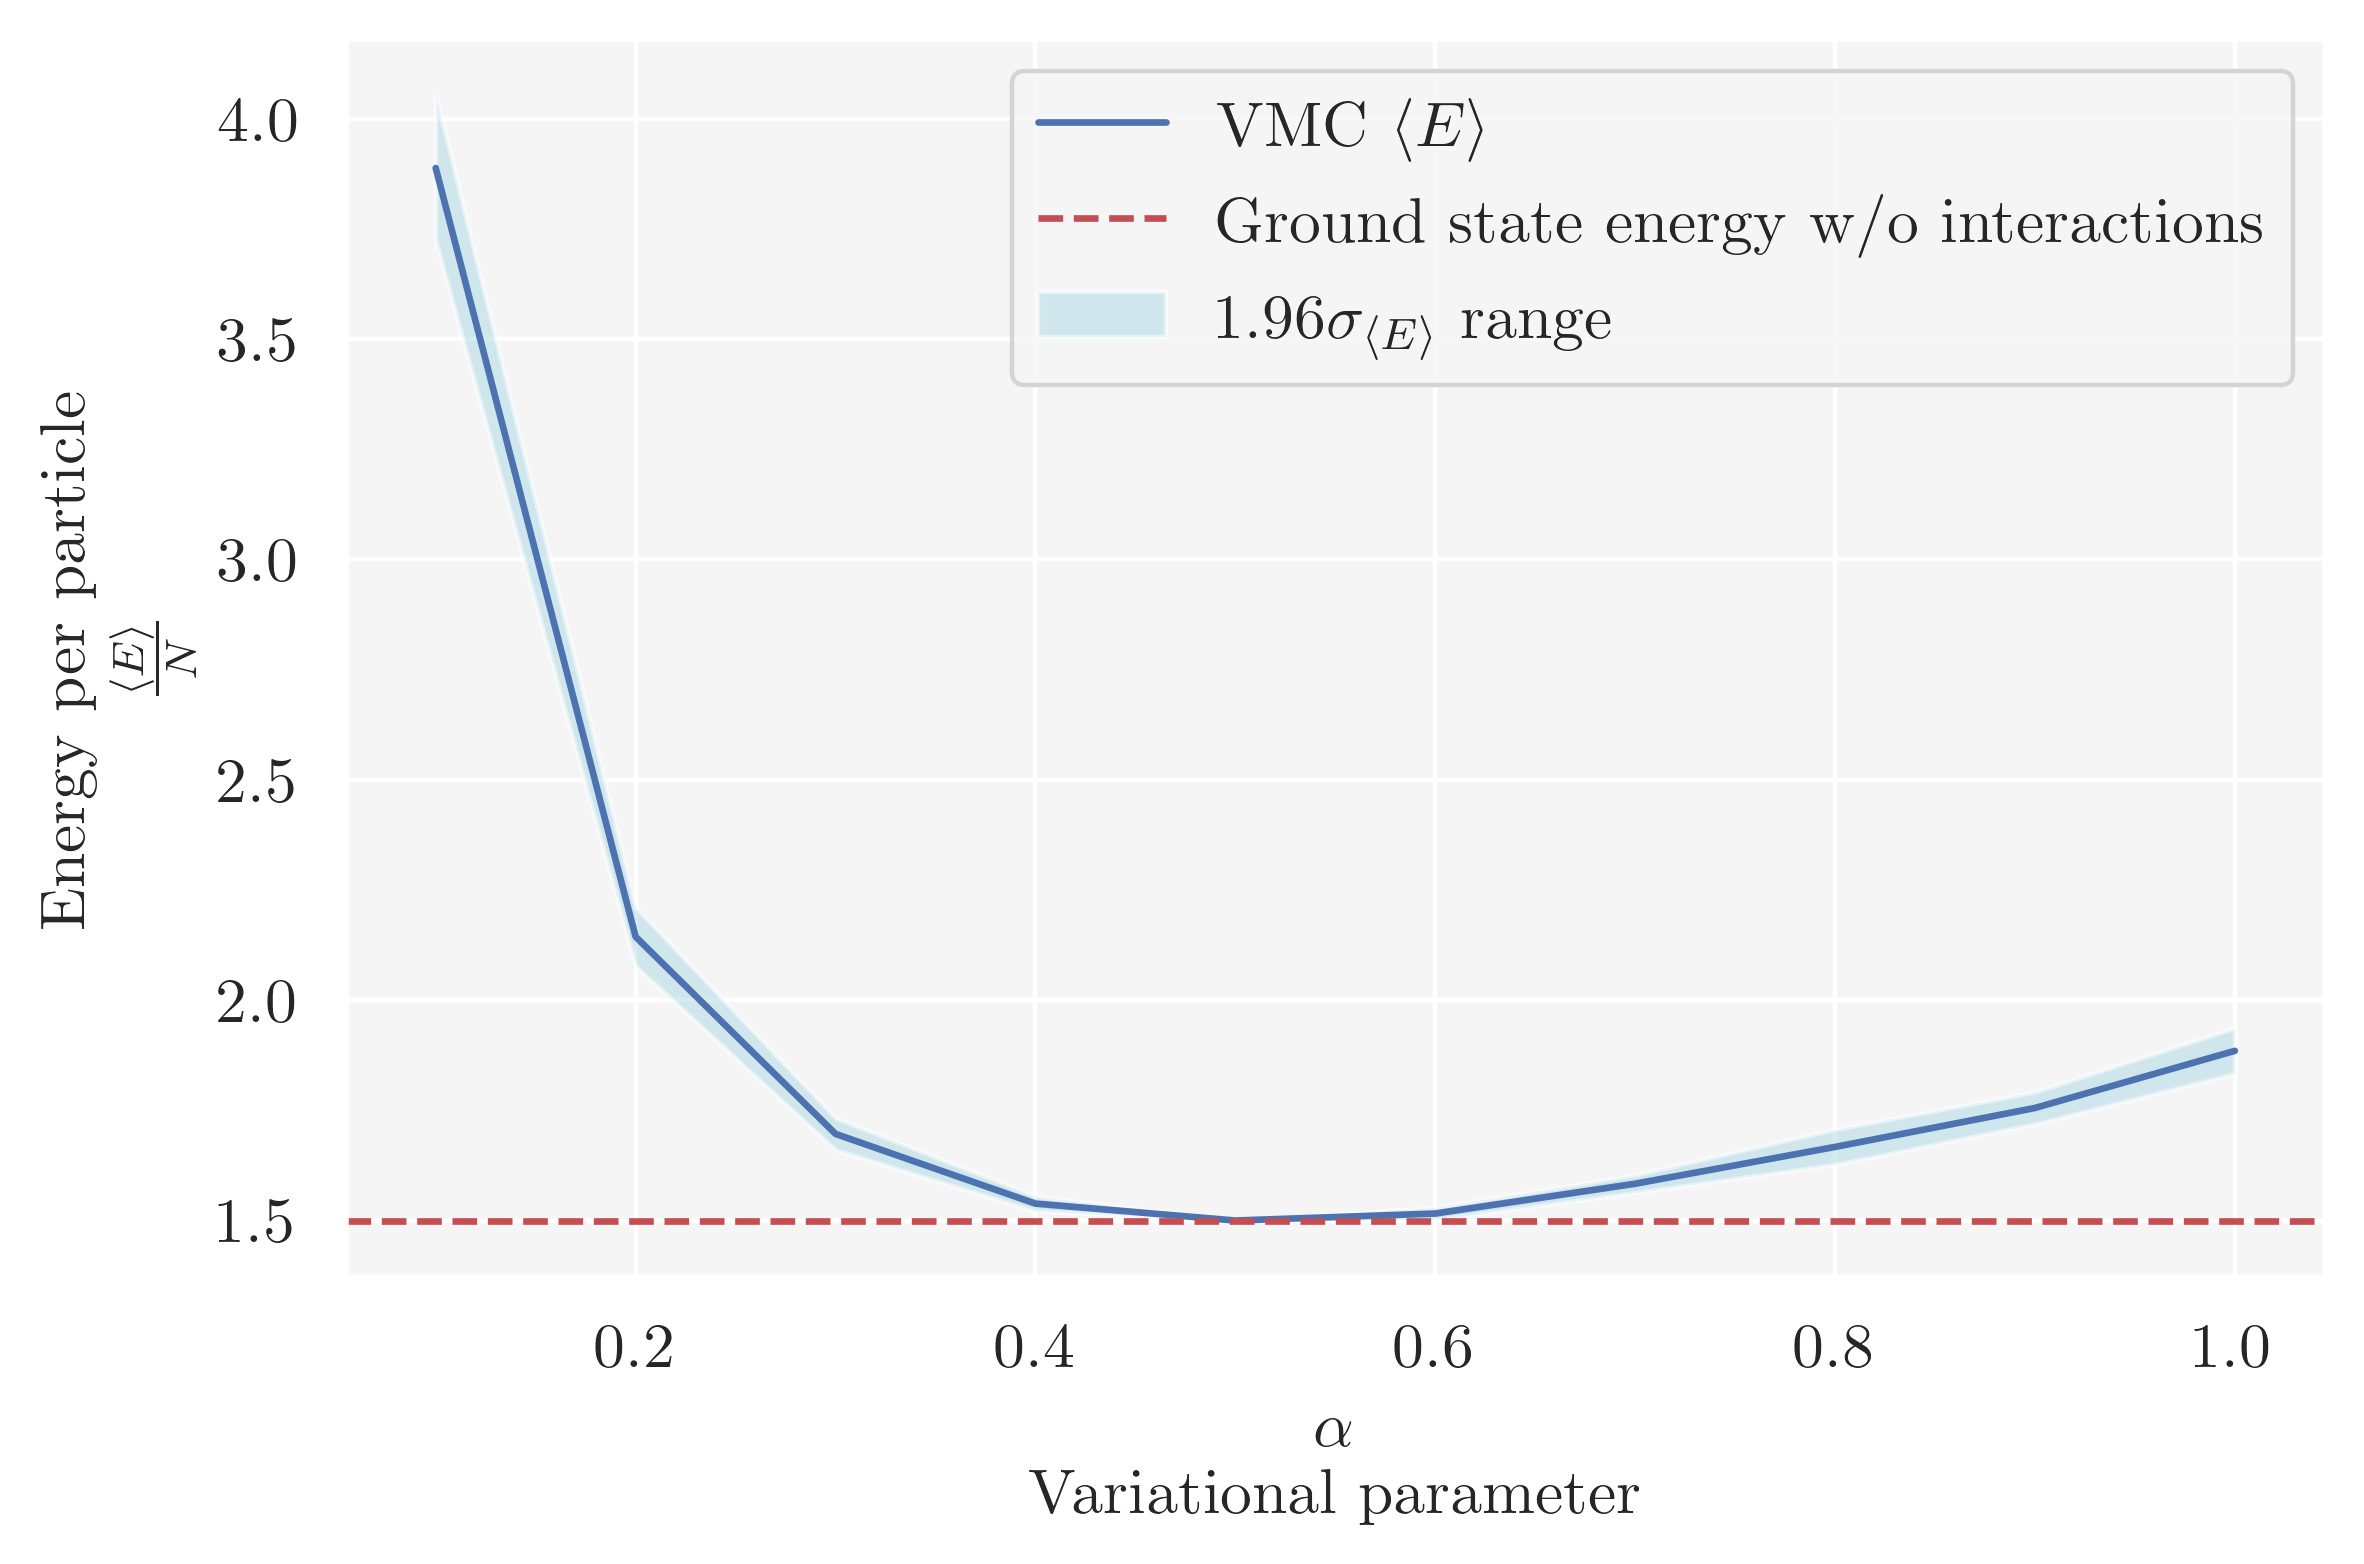

In [6]:
lower_bound = df_means_NI_N50["energy"] - 1.96*df_means_NI_N50["standard_error"]
upper_bound = df_means_NI_N50["energy"] + 1.96*df_means_NI_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_wo_interactions_N_50.pdf"), bbox_inches='tight')

## Grid search $\alpha$ with interactions

In [13]:
N = 10
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_I_N10 = []
distance_dict = {"alpha": alphas, "distances": []}

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=5000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    #distance_dict["distances"].append(sampler.distance_samples[0])
    results_I_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 553.2867426872253


In [40]:
N=10
df_N10 = pd.concat(results_I_N10, ignore_index=True)
df_means_N10 = get_mean_w_standard_error_grid_search(df_N10, alphas)
df_means_N10["energy"] = df_means_N10["energy"]/N
df_means_N10["standard_error"] = df_means_N10["standard_error"]/N
df_means_N10["standard_error"] = df_means_N10["standard_error"].map('{:.0e}'.format)
df_means_N10["standard_error_of_the_mean"] = df_means_N10["standard_error_of_the_mean"]/N
df_means_N10

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.100,3.929,5e-02,0.001
1,0.200,2.210,2e-02,0.001
2,0.300,1.713,1e-02,0.000
3,0.400,1.542,4e-03,0.000
4,0.500,1.517,8e-05,0.000
5,0.600,1.544,5e-03,0.000
6,0.700,1.610,7e-03,0.000
7,0.800,1.699,9e-03,0.000
8,0.900,1.798,1e-02,0.001
9,1.000,1.913,1e-02,0.001


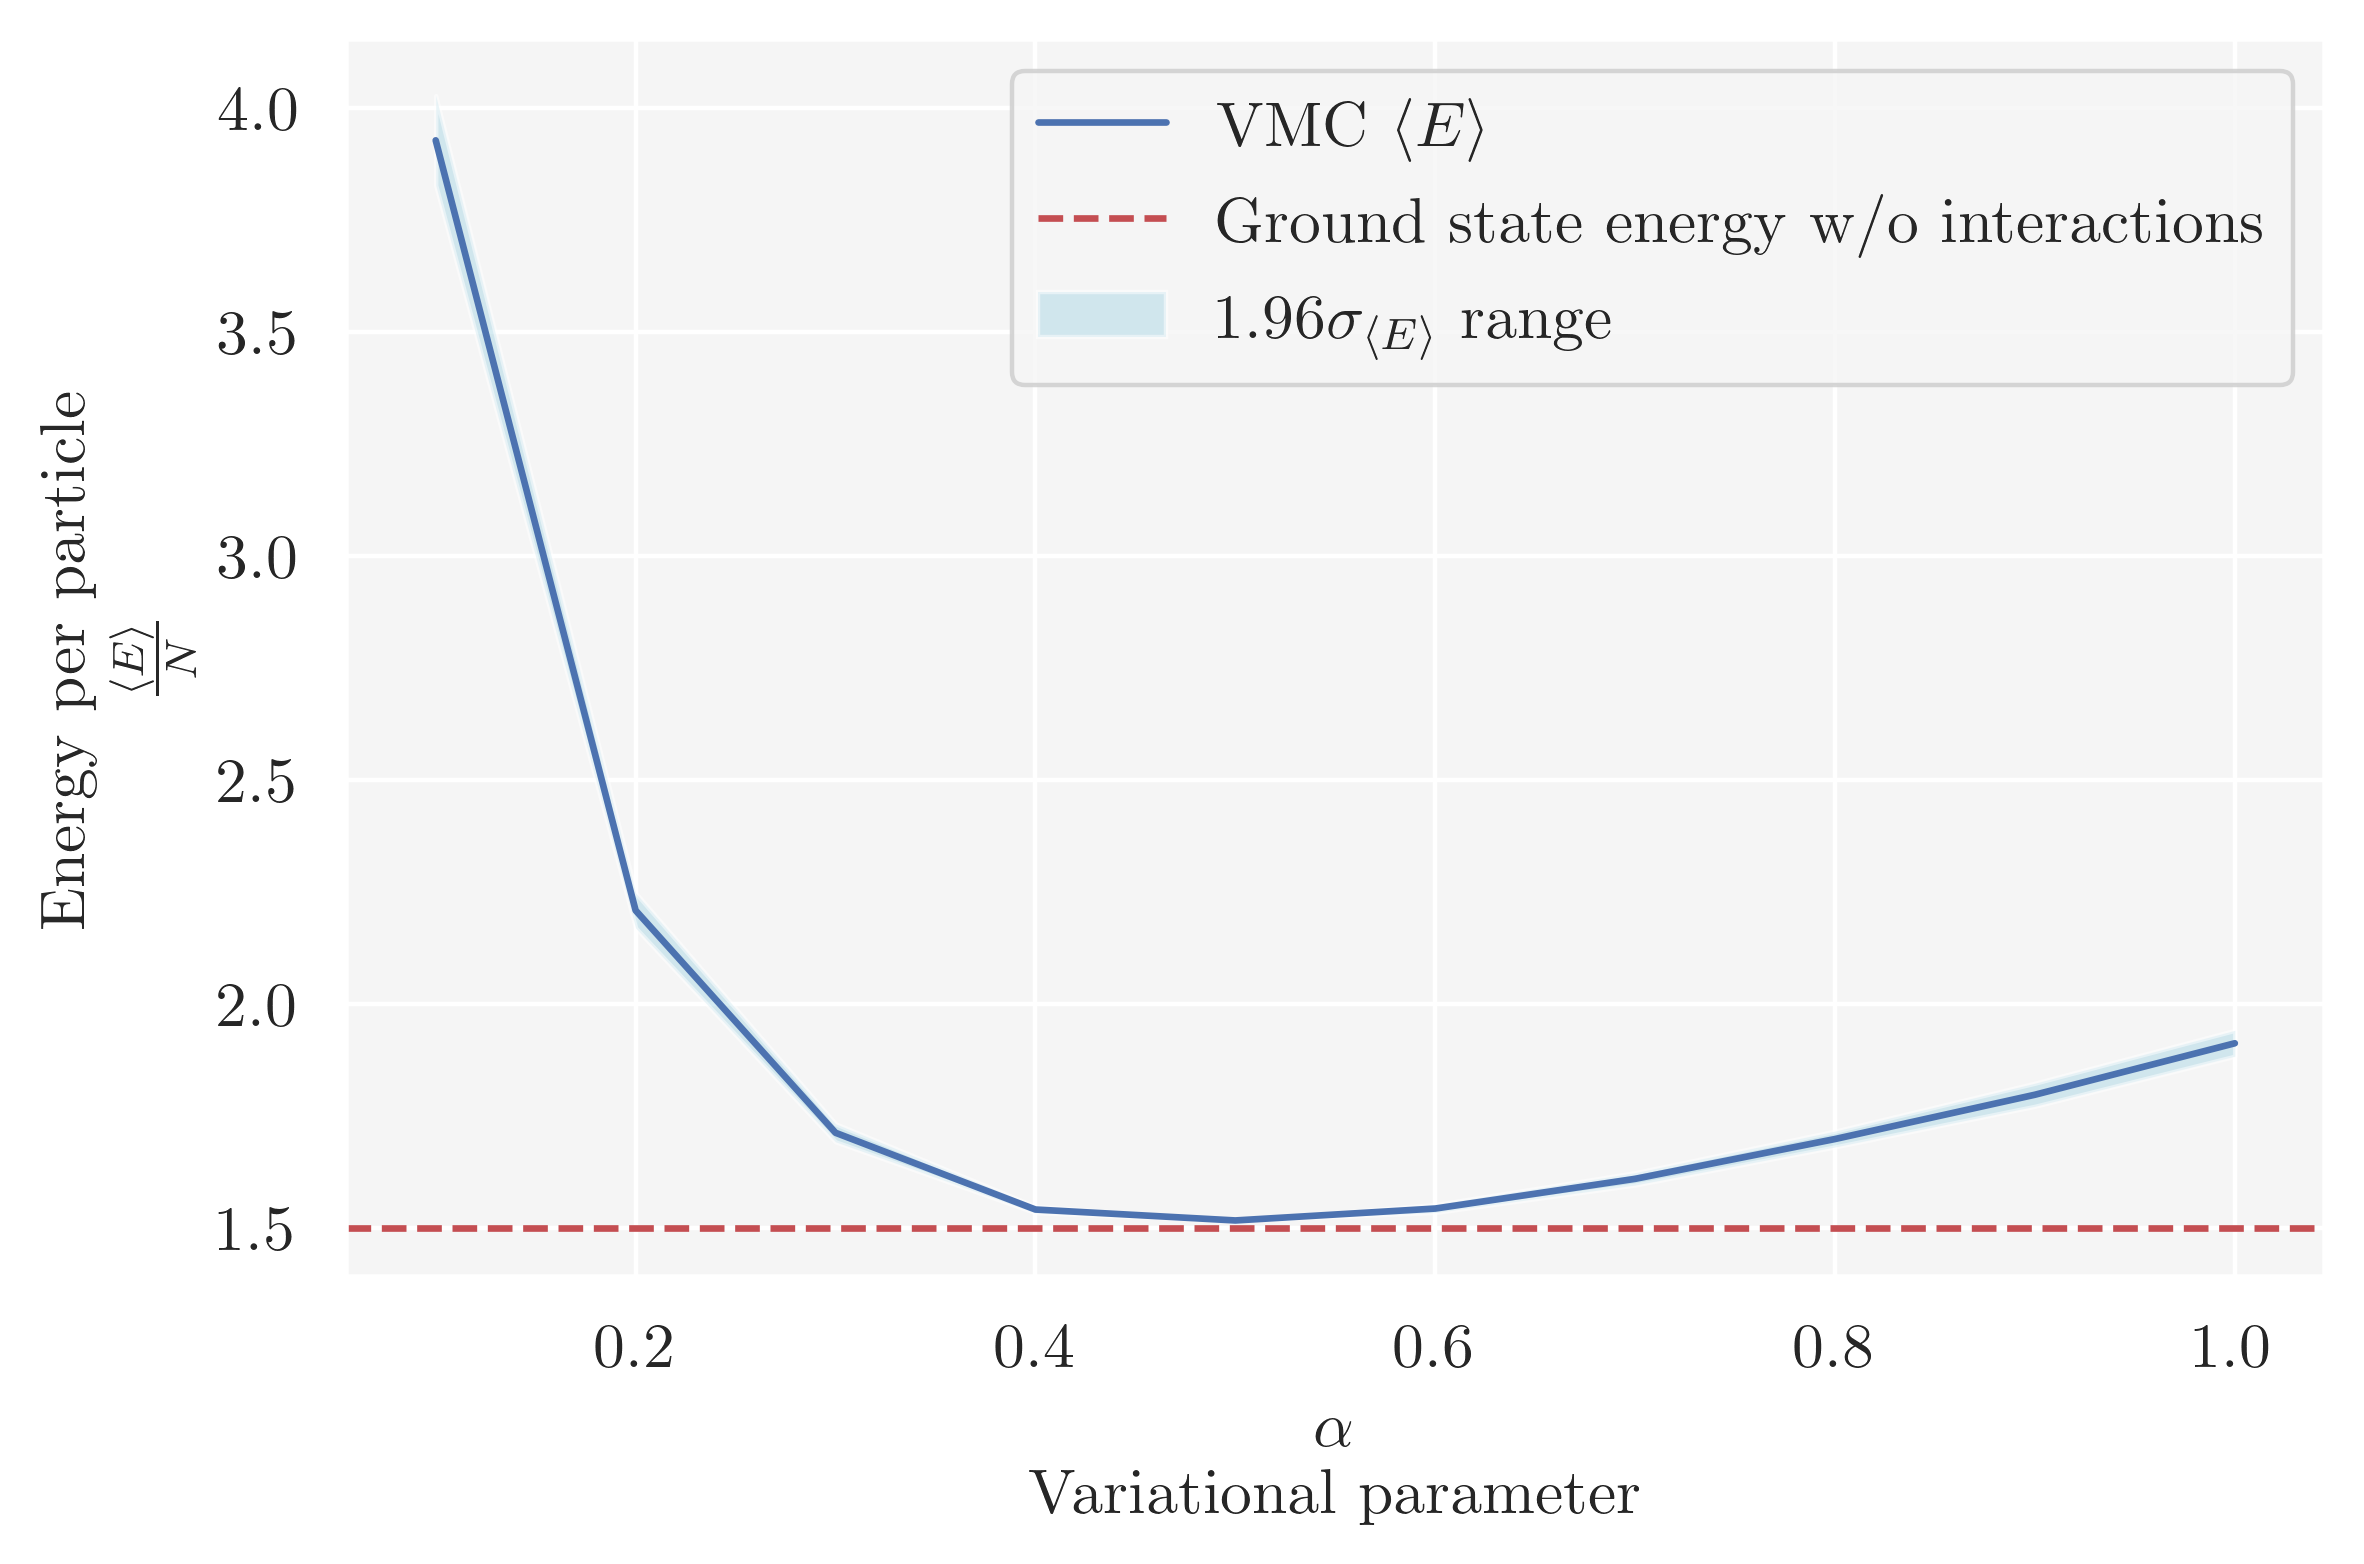

In [15]:
lower_bound_N10 = df_means_N10["energy"] - 1.96*df_means_N10["standard_error"]
upper_bound_N10 = df_means_N10["energy"] + 1.96*df_means_N10["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N10, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N10["alpha"], lower_bound_N10, upper_bound_N10, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_10.pdf"), bbox_inches='tight')

In [16]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_50 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N50 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=10000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N50.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 1094.8664512634277


In [41]:
N=50
df_N50 = pd.concat(results_N50, ignore_index=True)
df_means_N50 = get_mean_w_standard_error_grid_search(df_N50, alphas)
df_means_N50["energy"] = df_means_N50["energy"]/N
df_means_N50["standard_error"] = df_means_N50["standard_error"]/N
df_means_N50["standard_error"] = df_means_N50["standard_error"].map('{:.0e}'.format)
df_means_N50["standard_error_of_the_mean"] = df_means_N50["standard_error_of_the_mean"]/N
df_means_N50

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.100,3.989,1e-01,0.008
1,0.200,2.237,3e-02,0.001
2,0.300,1.752,2e-02,0.003
3,0.400,1.623,8e-03,0.001
4,0.500,1.595,3e-04,0.000
5,0.600,1.635,6e-03,0.000
6,0.700,1.709,1e-02,0.000
7,0.800,1.778,2e-02,0.003
8,0.900,1.898,2e-02,0.001
9,1.000,2.018,2e-02,0.001


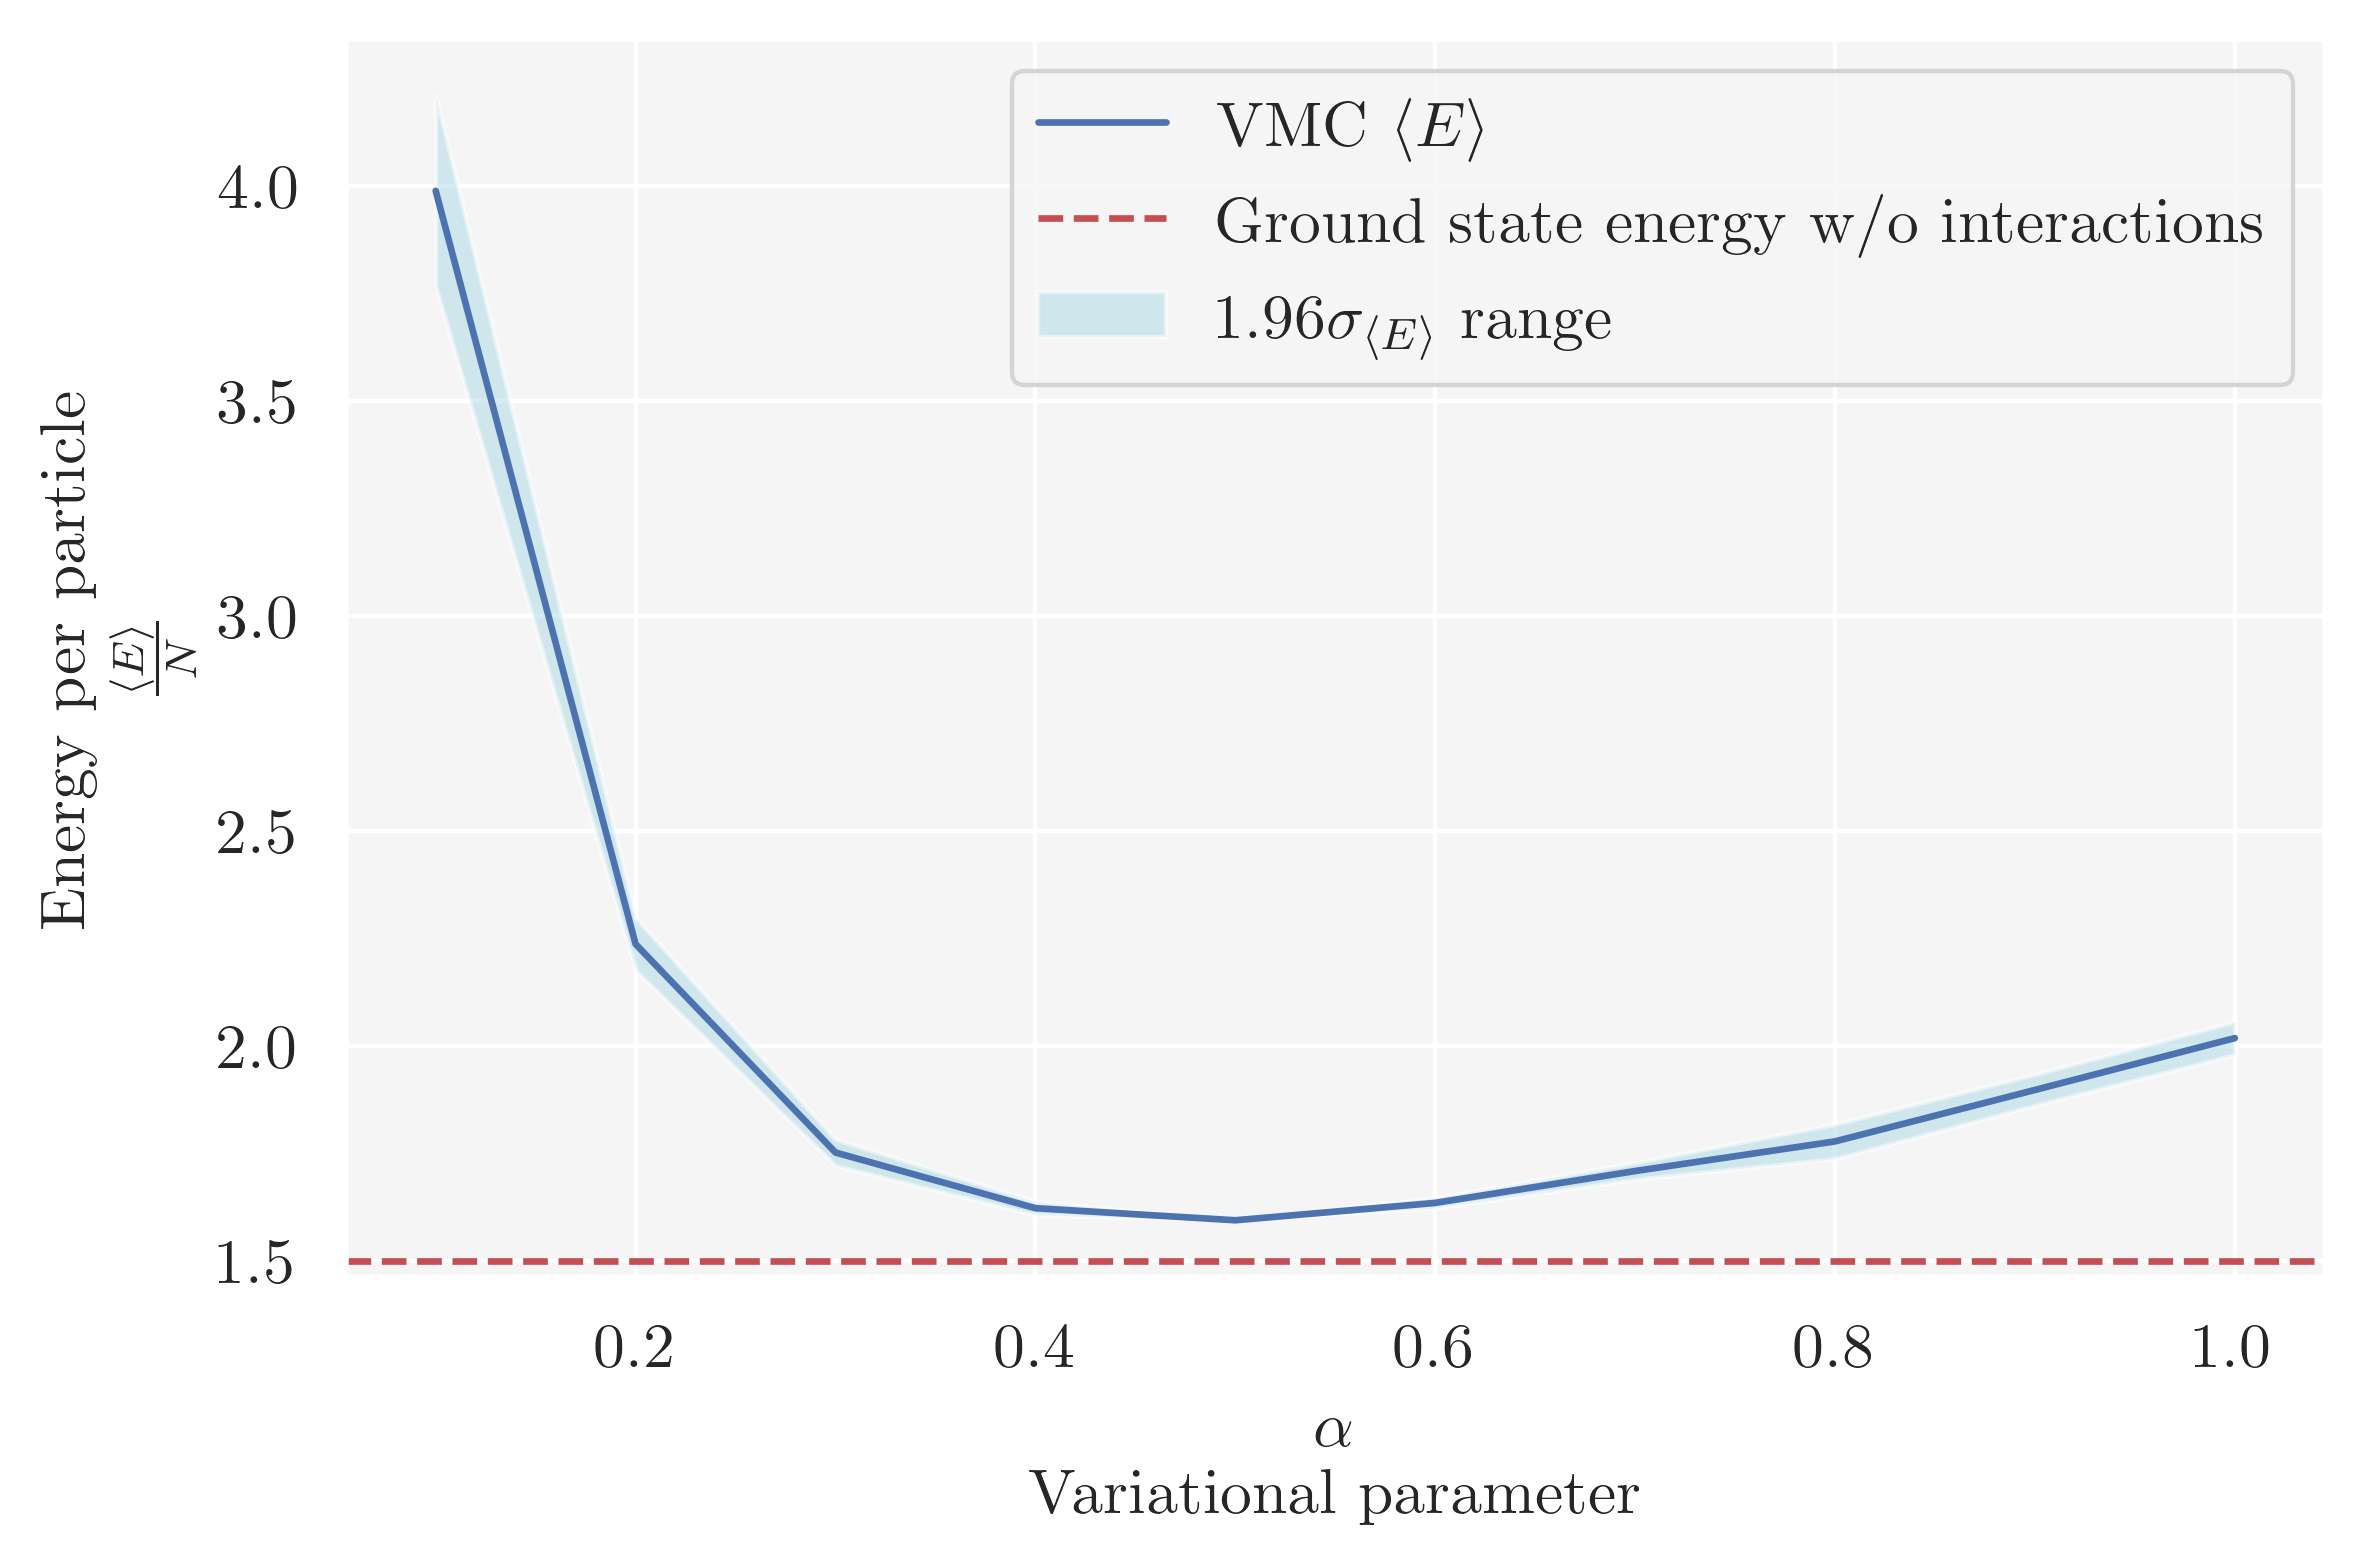

In [18]:
lower_bound_N50 = df_means_N50["energy"] - 1.96*df_means_N50["standard_error"]
upper_bound_N50 = df_means_N50["energy"] + 1.96*df_means_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N50["alpha"], lower_bound_N50, upper_bound_N50, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_50.pdf"), bbox_inches='tight')

In [19]:
N = 100
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_100 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N100 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=15000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N100.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Sampler elapsed time: 4857.963691234589


In [42]:
N=100
df_N100 = pd.concat(results_N100, ignore_index=True)
df_means_N100 = get_mean_w_standard_error_grid_search(df_N100, alphas)
df_means_N100["energy"] = df_means_N100["energy"]/N
df_means_N100["standard_error"] = df_means_N100["standard_error"]/N
df_means_N100["standard_error"] = df_means_N100["standard_error"].map('{:.0e}'.format)
df_means_N100["standard_error_of_the_mean"] = df_means_N100["standard_error_of_the_mean"]/N
df_means_N100

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.100,4.064,6e-02,0.001
1,0.200,2.300,3e-02,0.002
2,0.300,1.854,2e-02,0.003
3,0.400,1.705,8e-03,0.001
4,0.500,1.669,3e-04,0.000
5,0.600,1.708,5e-03,0.000
6,0.700,1.786,9e-03,0.001
7,0.800,1.875,2e-02,0.004
8,0.900,2.022,2e-02,0.004
9,1.000,2.147,3e-02,0.001


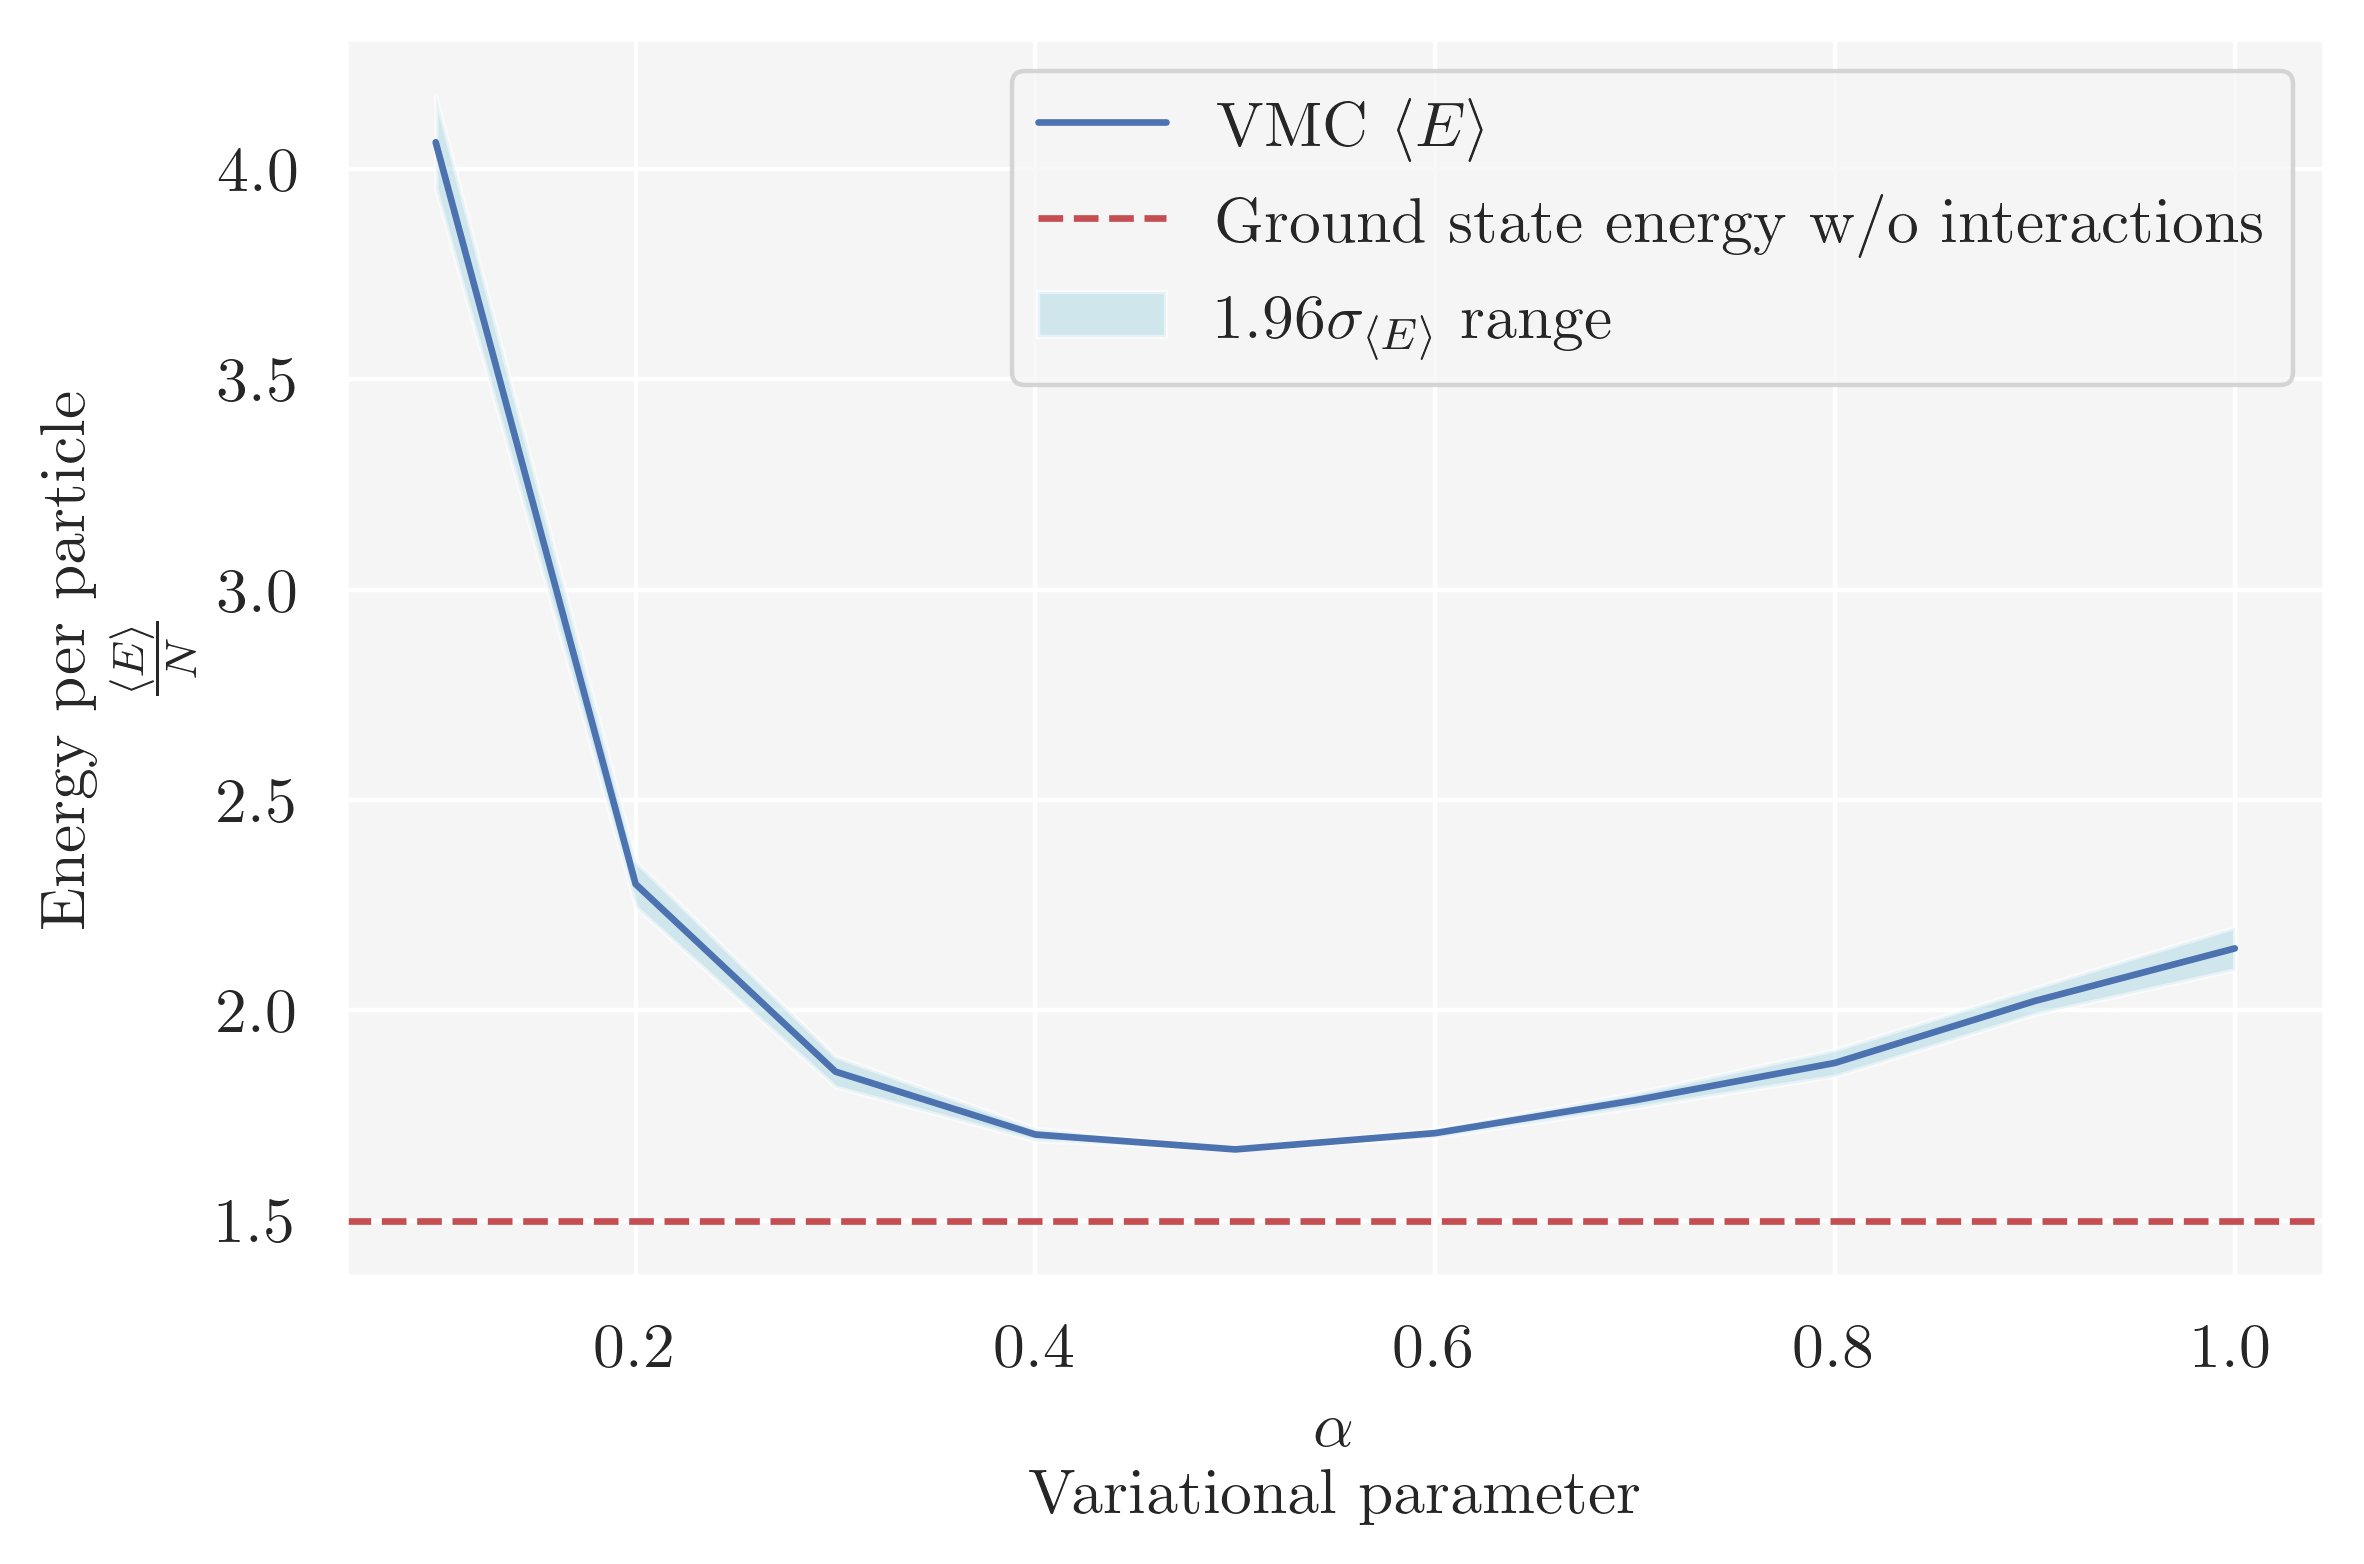

In [21]:
lower_bound_N100 = df_means_N100["energy"] - 1.96*df_means_N100["standard_error"]
upper_bound_N100 = df_means_N100["energy"] + 1.96*df_means_N100["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N100, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N100["alpha"], lower_bound_N100, upper_bound_N100, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_100.pdf"), bbox_inches='tight')

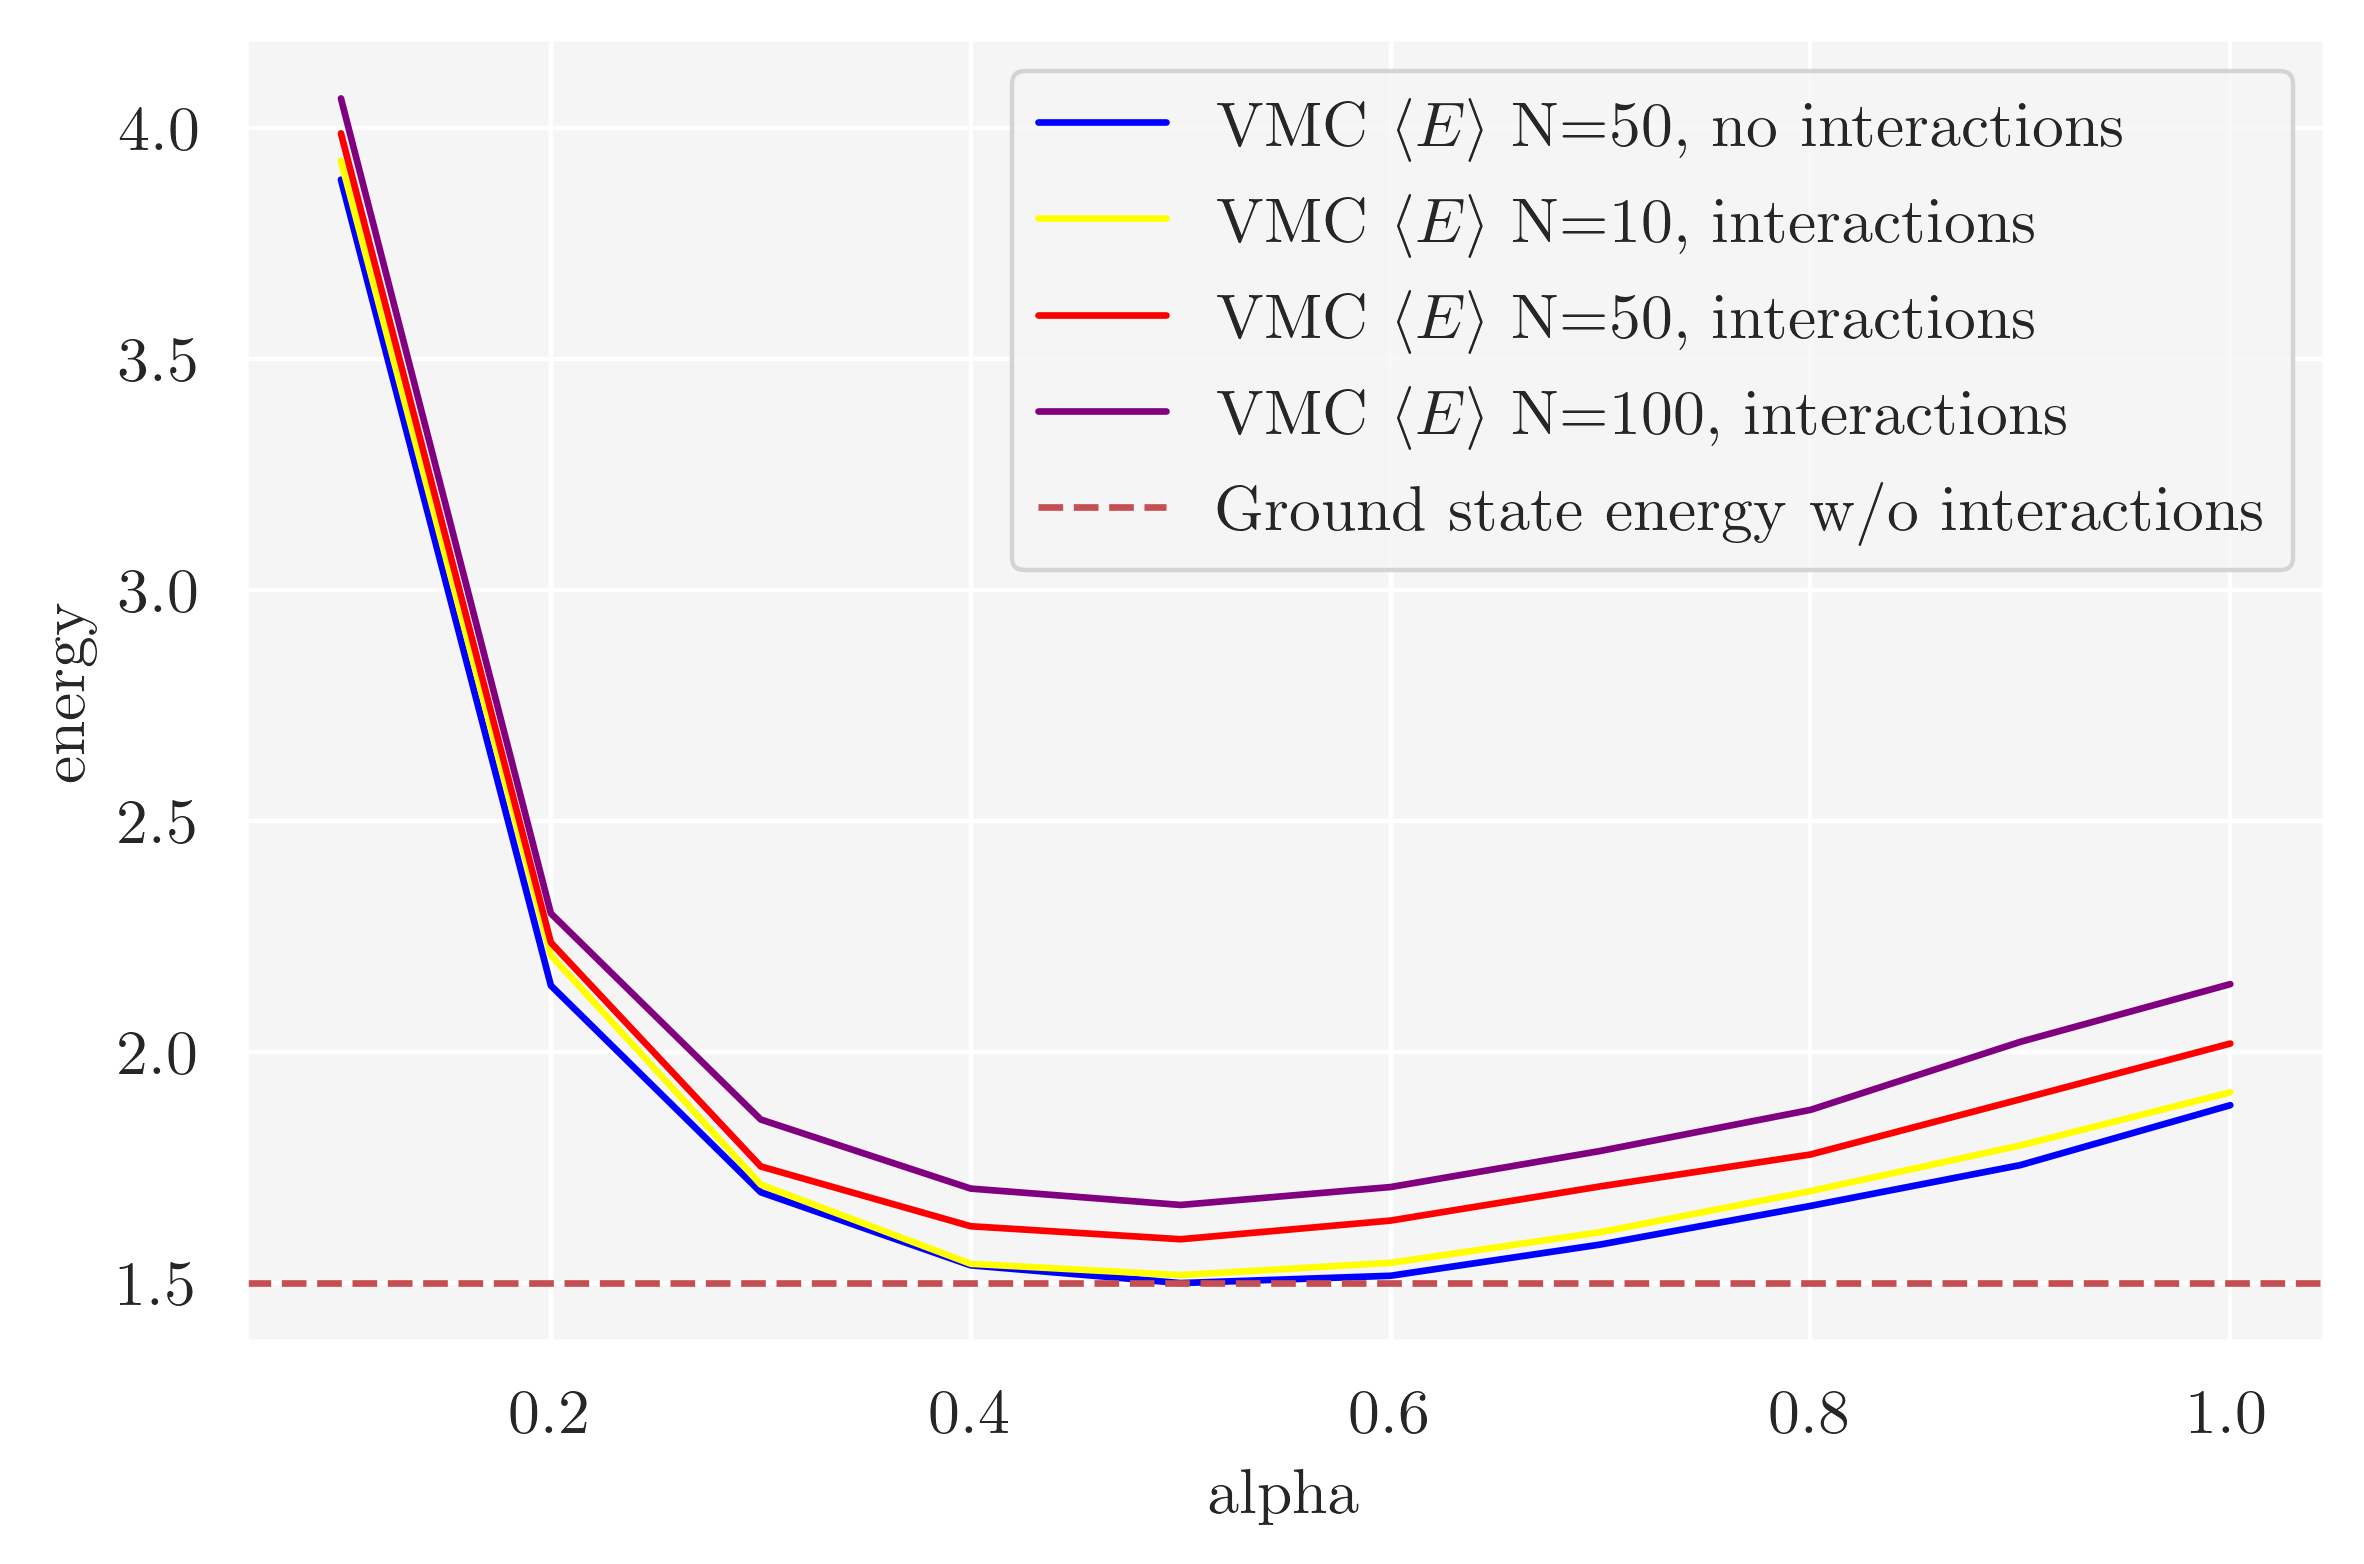

In [22]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
no_int_label = '\n'.join((r'VMC $\langle E\rangle$ N=50',
                         'No interactions'))
label_sigma_no_int = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '50 non-interacting particles'))
label_sigma_10 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '10 interacting particles'))
label_sigma_50 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '50 interacting particles'))
label_sigma_100 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '100 interacting particles'))
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, color="blue", label=r'VMC $\langle E\rangle$ N=50, no interactions')
#ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5)
               #label=label_sigma_no_int)
sns.lineplot(data=df_means_N10, x="alpha", y="energy", ax=ax, color="yellow", label=r'VMC $\langle E \rangle$ N=10, interactions')
#ax.fill_between(df_means_N10["alpha"], lower_bound_N10, upper_bound_N10, facecolor='gold', alpha=0.5)
                #label=label_sigma_10)
sns.lineplot(data=df_means_N50, x="alpha", y="energy", ax=ax, color="red", label=r'VMC $\langle E\rangle$ N=50, interactions')
#ax.fill_between(df_means_N50["alpha"], lower_bound_N50, upper_bound_N50, facecolor='tomato', alpha=0.5)
                #label=label_sigma_50)
sns.lineplot(data=df_means_N100, x="alpha", y="energy", ax=ax, color="purple", label=r'VMC $\langle E\rangle$ N=100, interactions')
#ax.fill_between(df_means_N100["alpha"], lower_bound_N100, upper_bound_N100, facecolor='magenta', alpha=0.5)
                #label=label_sigma_100)
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_all_N.pdf"), bbox_inches='tight')

### Making table for $\alpha=0.5$

In [54]:
table = {"Number of particles": [50, 10, 50, 100], "Interactions": ["Off", "On", "On", "On"], "Lowest energy": [], "Error": [], "Optimal alpha": [0.5, 0.5, 0.5, 0.5]}
table["Lowest energy"].append(df_means_NI_N50["energy"][4])
table["Lowest energy"].append(df_means_N10["energy"][4])
table["Lowest energy"].append(df_means_N50["energy"][4])
table["Lowest energy"].append(df_means_N100["energy"][4])
table["Error"].append(df_means_NI_N50["standard_error"][4])
table["Error"].append(df_means_N10["standard_error"][4])
table["Error"].append(df_means_N50["standard_error"][4])
table["Error"].append(df_means_N100["standard_error"][4])
table = pd.DataFrame(data=table)
table["Lowest energy"] = table["Lowest energy"].map('{:.5f}'.format)

#df_to_latex(table, "energy_table.tex")
table

,Number of particles,Interactions,Lowest energy,Error,Optimal alpha
0,50,Off,1.50000,0e+00,0.500
1,10,On,1.51731,8e-05,0.500
2,50,On,1.59490,3e-04,0.500
3,100,On,1.66912,3e-04,0.500
